In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import pandas as pd
from utils.SampleBuilder import SampleBuilder
from similarity.jaccard import Jaccard
from utils.explainer import Explainer
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi

## Try to change time

In [4]:
import random as rd
def generateRandomTime(maxMin = 9):
    minutes = str(rd.randint(1,maxMin))
    seconds = rd.randint(0,60)
    if seconds <=9:
        seconds = str(0)+str(seconds)
    else:
        seconds = str(seconds)
    return minutes+":"+seconds

In [8]:
def addOffset(time,offset):
    tokens = time.split(':')
    minutes = tokens[0]
    seconds = int(tokens[1])+offset
    return minutes+":"+str(seconds)

In [10]:
train_df = pd.read_csv('../Structured/itunes-amazon/merged_train.csv')
train_index = train_df.index
for idx in train_index:
    ltime = train_df.at[idx,'ltable_Time']
    rtime = train_df.at[idx,'rtable_Time']
    if ltime == rtime:
        train_df.at[idx,'ltable_Time'] = addOffset(ltime,15)

In [11]:
train_df.to_csv('../Structured/itunes-amazon/train_difftime.csv',index=False)

In [12]:
train,validation,test = dm.data.process('../Structured/itunes-amazon/'
                                        ,train='train_difftime.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [13]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,validation,epochs=20,best_save_path='../models/itunes_amazon_difftime.pth',
                      pos_neg_ratio=4)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:    4.1 | Load Time:    1.0 || F1:  41.31 | Prec:  27.75 | Rec:  80.77 || Ex/s:  62.81

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.4 | Load Time:    0.3 || F1:  42.62 | Prec:  27.37 | Rec:  96.30 || Ex/s: 159.60

* Best F1: 42.622950819672134
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:    3.7 | Load Time:    1.0 || F1:  57.03 | Prec:  41.01 | Rec:  93.59 || Ex/s:  68.95

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.4 | Load Time:    0.3 || F1:  60.00 | Prec:  54.55 | Rec:  66.67 || Ex/s: 161.21

* Best F1: 60.0
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:    4.6 | Load Time:    1.3 || F1:  69.35 | Prec:  57.02 | Rec:  88.46 || Ex/s:  55.10

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.5 | Load Time:    0.4 || F1:  64.41 | Prec:  59.38 | Rec:  70.37 || Ex/s: 

73.6842105263158

In [14]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.5 | Load Time:    0.4 || F1:  81.97 | Prec:  73.53 | Rec:  92.59 || Ex/s: 124.84



81.96721311475412

## Recompute Ri

In [16]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../models/itunes_amazon_difftime.pth')
hybrid_model = hybrid_model.cuda()

In [18]:
negatives = return_layer_input('../Structured/itunes-amazon','negatives',128,hybrid_model,
                                                                        hybrid_model.classifier)
positives = return_layer_input('../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier)

In [20]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']
classifier_len_hybrid = len(list(negatives.values())[0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))
negatives_ri,neg_ri_norms= computeRi(hybrid_model.classifier,
                                                    attributes,negatives,attribute_len_hybrid,1)

100%|██████████| 407/407 [00:37<00:00, 10.82it/s]


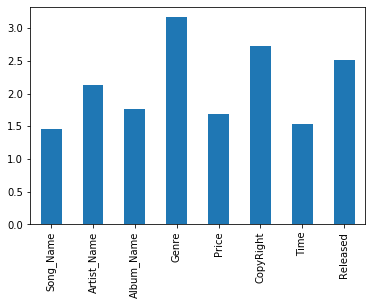

In [22]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
neg_variation_df.mean().plot.bar()

## Constant time

In [6]:
train_df = pd.read_csv('../Structured/itunes-amazon/merged_train.csv')
train_df['ltable_Time'] = "constant"
train_df['rtable_Time'] = "constant"
train_df.to_csv('train_constantTime.csv',index=False)

In [7]:
!cp ../Structured/itunes-amazon/merged_valid.csv ./
!cp ../Structured/itunes-amazon/merged_test.csv ./

In [8]:
train,validation,test = dm.data.process('./',train='train_constantTime.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [9]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,validation,epochs=20,best_save_path='../models/itunes_amazon_hybridConstTime.pth',
                      pos_neg_ratio=4)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:    4.7 | Load Time:    1.2 || F1:  46.98 | Prec:  32.51 | Rec:  84.62 || Ex/s:  54.18

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.5 | Load Time:    0.4 || F1:  53.93 | Prec:  38.71 | Rec:  88.89 || Ex/s: 121.12

* Best F1: 53.93258426966292
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:    4.5 | Load Time:    1.2 || F1:  61.40 | Prec:  46.67 | Rec:  89.74 || Ex/s:  55.52

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.5 | Load Time:    0.4 || F1:  55.88 | Prec:  46.34 | Rec:  70.37 || Ex/s: 115.38

* Best F1: 55.88235294117647
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:    4.6 | Load Time:    1.3 || F1:  66.35 | Prec:  52.63 | Rec:  89.74 || Ex/s:  54.82

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.5 | Load Time:    0.4 || F1:  67.92 | Prec:  69.23 | Rec:  66.

77.19298245614034

In [10]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.5 | Load Time:    0.4 || F1:  83.33 | Prec:  75.76 | Rec:  92.59 || Ex/s: 124.06



83.33333333333331

In [12]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../models/itunes_amazon_hybridConstTime.pth')
hybrid_model = hybrid_model.cuda()

In [13]:
negatives,neg_ids = return_layer_input('../Structured/itunes-amazon','negatives',128,hybrid_model,
                                                                        hybrid_model.classifier)
positives,pos_ids = return_layer_input('../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier)

In [14]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']
classifier_len_hybrid = len(negatives[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))
negatives_ri,neg_ri_norms= computeRi(hybrid_model.classifier,
                                                    attributes,negatives,attribute_len_hybrid,1)

100%|██████████| 128/128 [00:14<00:00,  8.72it/s]


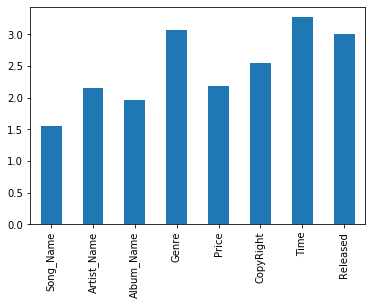

In [16]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
neg_variation_df.mean().plot.bar()

In [29]:
model1 = dm.MatchingModel(attr_summarizer='hybrid')
model1.load_state('../models/itunes_amazon_hybrid.pth')
explainer = Explainer(model1,5)

In [31]:
!mkdir temp

In [32]:
test_negatives = pd.read_csv('../Structured/itunes-amazon/test_negatives.csv')
leftTimes = test_negatives.ltable_Time
explainer.testRobustness('../Structured/itunes-amazon/test_negatives.csv',0,'Time',[leftTimes,leftTimes],
                        strategy='replace')

===>  PREDICT Epoch 3
Finished Epoch 3 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 3
Finished Epoch 3 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(77, 0)

In [33]:
model2 = dm.MatchingModel(attr_summarizer='hybrid')
model2.load_state('../models/itunes_amazon_hybridRdtimes.pth')
explainer = Explainer(model2,5)

In [34]:
explainer.testRobustness('../Structured/itunes-amazon/test_negatives.csv',0,'Time',[leftTimes,leftTimes],
                        strategy='replace')

===>  PREDICT Epoch 11
Finished Epoch 11 || Run Time:    0.3 | Load Time:    0.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 11
Finished Epoch 11 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(75, 62)

## Positive analysis

In [37]:
hybrid_model = model2.cuda()
negatives_ri,neg_ri_norms= computeRi(hybrid_model.classifier,
                                                    attributes,positives,attribute_len_hybrid,0)

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
